# BIZI system

Let's analyze the evolution of uses of the public bicycles system in Zaragoza (Spain). The data goes from June 2008 to June 2019. 

In [1]:
import pymc3 as pm
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

plt.style.use('seaborn-darkgrid')

In [2]:
path = "bizi/"
all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat([pd.read_csv(f, sep=";", header=0) for f in all_files])

In [3]:
df['DataTimeRemoval'] =  pd.to_datetime(df['DataTimeRemoval'], 
                                        format='%Y%m%d %H:%M:%S')
df = df.sort_values(by="DataTimeRemoval")
df

,CustID,CustSex,LustroNacimiento,DataTimeRemoval,Removal_Station,DateTime_Arrival,Arrival_station,LocationLength
0,158,F,16,2008-05-28 10:55:06,10,2008-05-28 11:04:32.000,11,9
1,391,F,16,2008-05-28 10:55:24,10,2008-05-28 11:04:49.000,11,9
2,408,F,16,2008-05-28 10:55:52,10,2008-05-28 11:04:48.000,11,8
3,441,F,16,2008-05-28 10:56:00,10,2008-05-28 11:04:47.000,11,8
4,406,F,16,2008-05-28 10:56:12,10,2008-05-28 11:05:01.000,11,8
...,...,...,...,...,...,...,...,...
899109,71686,M,18,2019-07-14 00:55:02,99,2019-07-14 01:23:00.950,46,27
899110,93235,M,17,2019-07-14 00:55:29,100,2019-07-14 01:04:18.980,53,8
899111,83379,M,19,2019-07-14 00:57:14,43,2019-07-14 01:04:19.027,49,7
899112,98468,M,20,2019-07-14 00:57:47,55,2019-07-14 01:52:10.330,4,54


In [4]:
df["Year"] = df["DataTimeRemoval"].dt.to_period('Y').dt.to_timestamp()

In [5]:
#NUMBER OF MEN AND WOMEN
df_user=df.groupby(["CustID"]).size().reset_index(name="counts")
df_user=df_user.sort_values(by="CustID")

df_MF = df.groupby(["CustSex"]).size().reset_index(name="counts")
df_MF = df_MF.sort_values(by="CustSex")
print(df_MF)
tot=df_MF.counts[0] + df_MF.counts[1]
perM=df_MF.counts[0]*100/tot
print('A %f%% are women'%perM)
perF=df_MF.counts[1]*100/tot
print('A %f%% are men'%perF)
print('Total uses: %d'%tot)
print('Total users: %d'%df_user.shape[0])

  CustSex    counts
0       F   9267191
1       M  15267323
A 37.772059% are women
A 62.227941% are men
Total uses: 24534514
Total users: 72166


In [6]:
#USERS PER YEAR

df_year = df.groupby(["Year"]).size().reset_index(name="counts")
df_year = df_year.sort_values(by="Year")
df_year = df_year.iloc[1:-1]
df_year

,Year,counts
1,2009-01-01,1368912
2,2010-01-01,1947178
3,2011-01-01,3126817
4,2012-01-01,2962910
5,2013-01-01,2931972
6,2014-01-01,2875463
7,2015-01-01,2126363
8,2016-01-01,2123962
9,2017-01-01,2161577
10,2018-01-01,1824784


In [7]:
df["Year/Week"] = df["DataTimeRemoval"].dt.to_period('M').dt.to_timestamp()

In [8]:
df = df.groupby(["Year/Week"]).size().reset_index(name="counts")
df = df.sort_values(by="Year/Week")
df = df.iloc[1:-1]
df

,Year/Week,counts
1,2008-06-01,25478
2,2008-07-01,35894
3,2008-08-01,33281
4,2008-09-01,35003
5,2008-10-01,28573
...,...,...
129,2019-02-01,141482
130,2019-03-01,153041
131,2019-04-01,131069
132,2019-05-01,160803


Let's plot the datapoints, corresponding to the total uses per week.

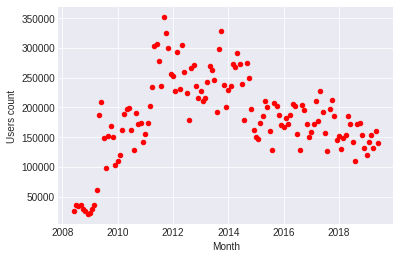

In [12]:
df.plot(x='Year/Week', y='counts', kind='scatter', color='red')
plt.ylabel("Users count")
plt.xlabel("Month");

In [13]:
points = df["counts"]

We will consider a model in which our data is assumed to be generated according to a negative binomial distribution.

In [14]:
def create_bikes_model(n_switchpoints):
    with pm.Model() as model:
        def create_switchpoint(id, lower, upper):
            return pm.DiscreteUniform(f'switchpoint_{id}', lower=lower, upper=upper)

        def create_rate(id, lower, upper):
            return pm.Uniform(f'rate_{id}', lower=lower, upper=upper) #average as a free parameter

        def build_switch(id):
            if id == 0:
                return pm.math.switch(switchpoints[0] >= weeks, rates[id], rates[id+1])
            else:
                return pm.math.switch(switchpoints[id] >= weeks, build_switch(id-1), rates[id+1])

        switchpoints = [create_switchpoint(0, 4, len(df["Year/Week"]) - n_switchpoints)]
        for i in range(1, n_switchpoints):
            switchpoints.append(create_switchpoint(i, switchpoints[i-1]+3, len(df["Year/Week"])-n_switchpoints+i))

        rates = []
        rates.append(create_rate(0, 0, 70000))
        rates.append(create_rate(1, 100000, 250000))
        rates.append(create_rate(2, 150000, 350000))
        
        if n_switchpoints == 4:
            rates.append(create_rate(3, 100000, 250000))
            rates.append(create_rate(4, 100000, 200000))
           
        if n_switchpoints == 5 or n_switchpoints == 6:
            rates.append(create_rate(3, 100000, 350000))
            rates.append(create_rate(4, 100000, 250000))
            rates.append(create_rate(5, 100000, 200000))
         
        if n_switchpoints == 6:
            rates.append(create_rate(6, 100000, 200000))            

        weeks = np.arange(0, len(df["Year/Week"]))
        variance = pm.Uniform('variance', 1, 1000) 

        rate = build_switch(n_switchpoints-1)
        #mu=rate; alpha=variance
        uses = pm.NegativeBinomial('uses', rate, variance, observed=points)
        #uses = pm.Poisson('uses', rate,observed=points)
    
    return model    

Let's try a model with 4 switchpoints.

In [15]:
with create_bikes_model(4) as model:
    trace = pm.sample(100000, tune = 5000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_4, rate_3, rate_2, rate_1, rate_0]


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 5_000 tune and 100_000 draw iterations (20_000 + 400_000 draws total) took 147 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [16]:

import datetime
from dateutil.relativedelta import relativedelta

print("First switchpoint:")
week_0=int(np.median(trace["posterior"]["switchpoint_0"]))
switch_0 = df["Year/Week"][1] + relativedelta(months = week_0)
print(switch_0)

print("Second switchpoint:")
week_1=int(np.median(trace["posterior"]["switchpoint_1"]))
switch_1 = df["Year/Week"][1] + relativedelta(months = week_1)
print(switch_1)

print("Third switchpoint:")
week_2=int(np.median(trace["posterior"]["switchpoint_2"]))
switch_2 = df["Year/Week"][1] + relativedelta(months = week_2)
print(switch_2)

print("Fourth switchpoint:")
week_3=int(np.median(trace["posterior"]["switchpoint_3"]))
switch_3 = df["Year/Week"][1] + relativedelta(months = week_3)
print(switch_3)

First switchpoint:
2009-04-01 00:00:00
Second switchpoint:
2011-02-01 00:00:00
Third switchpoint:
2014-10-01 00:00:00
Fourth switchpoint:
2017-11-01 00:00:00


In [17]:
az.summary(trace, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint_0,9.716,0.451,9.000,10.000,0.002,0.002,34478.0,34478.0,1.0
switchpoint_1,32.353,0.720,31.000,33.000,0.003,0.002,65613.0,66177.0,1.0
switchpoint_2,75.866,2.915,73.000,77.000,0.099,0.070,6196.0,2677.0,1.0
switchpoint_3,113.499,7.323,100.000,126.000,0.176,0.124,6014.0,2345.0,1.0
rate_0,31525.085,2200.332,27098.455,35670.659,7.632,5.397,84967.0,166357.0,1.0
rate_1,159007.249,6554.866,146144.755,171788.453,15.394,10.885,180236.0,247966.0,1.0
rate_2,255191.768,7620.732,240872.323,269651.782,73.230,54.758,24556.0,10933.0,1.0
rate_3,178808.553,9247.851,165752.512,190751.703,265.813,199.555,7565.0,2571.0,1.0
rate_4,149969.891,8435.088,133709.114,167651.520,91.726,67.852,9906.0,3365.0,1.0
variance,30.666,3.892,23.165,38.353,0.009,0.006,199748.0,275757.0,1.0


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  after removing the cwd from sys.path.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


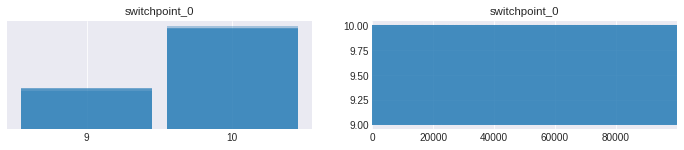

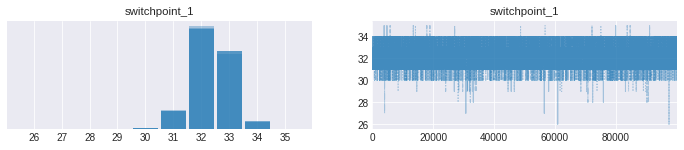

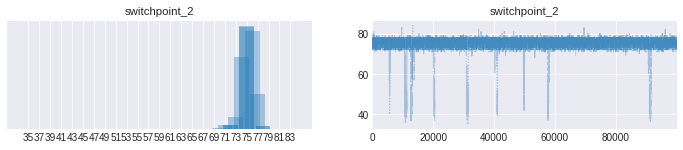

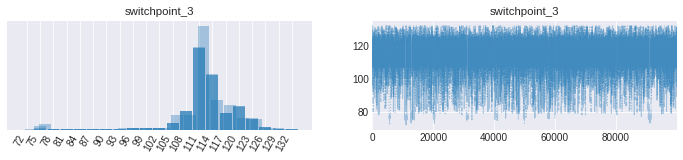

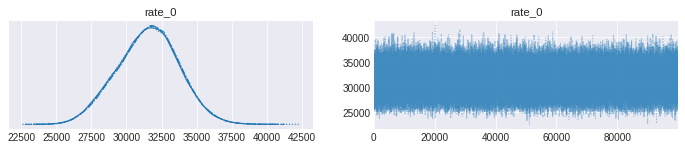

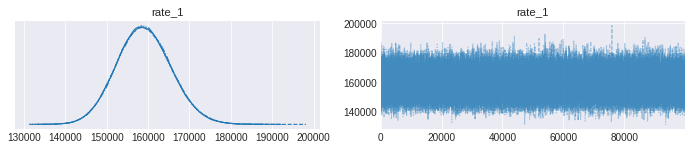

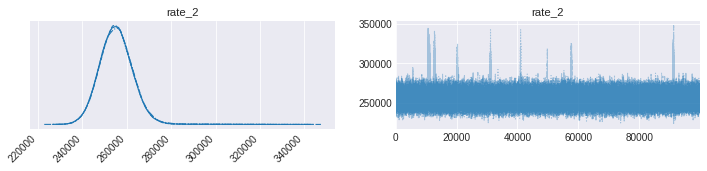

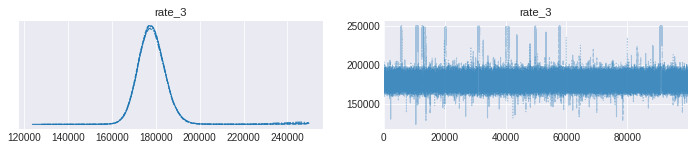

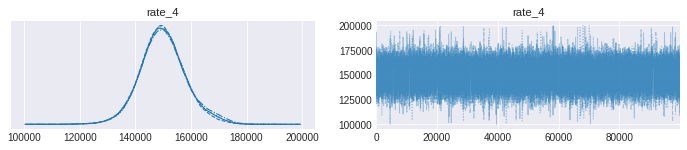

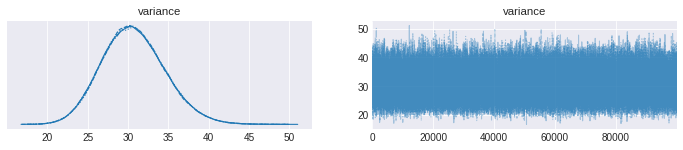

In [18]:
az.plot_trace(trace, var_names="switchpoint_0");
az.plot_trace(trace, var_names="switchpoint_1");
az.plot_trace(trace, var_names="switchpoint_2");
axes_arr = pm.traceplot(trace, var_names="switchpoint_3")
plt.draw() # this forces population of the xticklabels so that the get_text() works later.
for ax in axes_arr.flatten():
    if ax.get_title() == 'switchpoint_3': # find the right axes
        labels = [label.get_text() for label in ax.get_xticklabels()] # collect the existing labels.
        ax.set_xticklabels(labels, rotation=60, ha='right') # rotation here
        break
plt.draw()
az.plot_trace(trace, var_names="rate_0");
az.plot_trace(trace, var_names="rate_1");
axes_arr = pm.traceplot(trace, var_names="rate_2")
plt.draw() # this forces population of the xticklabels so that the get_text() works later.
for ax in axes_arr.flatten():
    if ax.get_title() == 'rate_2': # find the right axes
        labels2 = [label.get_text() for label in ax.get_xticklabels()] # collect the existing labels.
        ax.set_xticklabels(labels2, rotation=45, ha='right') # rotation here
        break
plt.draw()
az.plot_trace(trace, var_names="rate_3");
az.plot_trace(trace, var_names="rate_4");
az.plot_trace(trace, var_names="variance");

For completeness, let's run the model adding one and two more switchpoints.

In [74]:
#running traces for different n_switchpoint
traces = [] 
for i in range(4, 7):
    print(f"Running model with {i} switchpoints")
    with create_bikes_model(i) as model:
        traces.append(pm.sample(10000, tune = 5000, return_inferencedata=True))

Running model with 4 switchpoints


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_4, rate_3, rate_2, rate_1, rate_0]


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 24 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Running model with 5 switchpoints


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_4]
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_5, rate_4, rate_3, rate_2, rate_1, rate_0]


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 34 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4032513939101213, but should be close to 0.8. Try to increase the number of tuning ste

Running model with 6 switchpoints


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_5]
>>Metropolis: [switchpoint_4]
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_6, rate_5, rate_4, rate_3, rate_2, rate_1, rate_0]


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 40 seconds.
The acceptance probability does not match the target. It is 0.6918455164041669, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6014657631107228, b

In [38]:
prediction = [] 
m=0
for i in range(4, 7):
    print(f"Running model with {i} switchpoints")
    with create_bikes_model(4) as model:
        prediction.append(pm.sample_posterior_predictive(traces[m], 10000))
        m=m+1

Running model with 4 switchpoints


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Running model with 5 switchpoints


Running model with 6 switchpoints


Let's plot the evolution:

In [79]:
def layout (n_switchpoints, i):
    trace=traces[i]
    dates = pd.to_datetime(df["Year/Week"]).dt.strftime("%Y-%m-%d")
    plot_dates = [dates[i] for i in range(1, len(dates)-1, 20)]

    posterior_quantile = np.percentile(prediction[i]["uses"], [2.5, 25, 50, 75, 97.5], axis=0)

    # Plot daily number of admissions
    plt.plot(
        dates, posterior_quantile[2, :],
        color='b', label='posterior median', lw=2)

    plt.fill_between(
        dates, posterior_quantile[0, :], posterior_quantile[4, :],
        color='b', label='95% quantile', alpha=.2)

    plt.plot(
          dates, df["counts"],
          '--o', color='k', markersize=3,
          label='Observed', alpha=.8)

    for j in range(0, n_switchpoints):
        plt.vlines(np.median(trace["posterior"]["switchpoint_%s" %(j)]), df["counts"].min(), df["counts"].max(), color='C1')

    plt.xticks(plot_dates, rotation=30)
    plt.ylabel('Uses', fontsize='large')
    plt.xlabel('Month', fontsize='large')
    plt.title('With %s switchpoints'%n_switchpoints)

    fontsize = 'medium'
    plt.legend(loc='upper left', fontsize=fontsize)

    return plt.tight_layout();
    

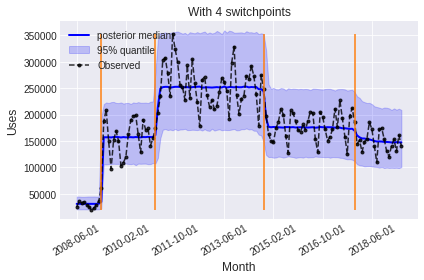

In [80]:
layout(4,0)

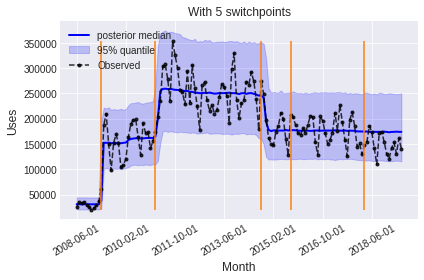

In [81]:
layout(5,1)

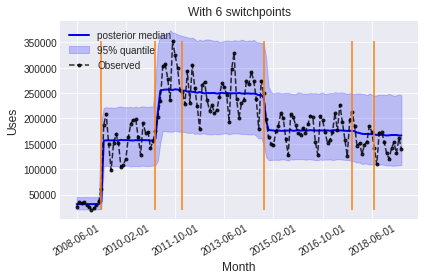

In [82]:
layout(6,2)

In [20]:
loo_4 = az.loo(traces[0], model)
loo_5 = az.loo(traces[1], model)
loo_6 = az.loo(traces[2], model)

df_comp_loo = az.compare({"four": traces[0], "five": traces[1], "six": traces[2]})
df_comp_loo


/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
four,0,-1567.634142,12.607474,0.000000,1.000000e+00,11.970789,0.000000,True,log
five,1,-1568.930354,15.972545,1.296212,1.665335e-16,11.934379,1.065277,True,log
six,2,-1569.651696,16.863860,2.017554,0.000000e+00,12.144167,1.308775,True,log


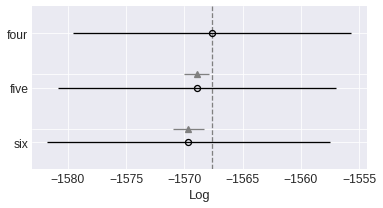

In [22]:
az.plot_compare(df_comp_loo, insample_dev=False);

According to the loo, the best model is the one with four switchpoints. Yet, when we look at the plot we can see that all models are compatible. Thus, we can choose whichever we prefer, or the one which is more reasonable given extra information. According to the plotted evolution and news, we conclude:

- The service started in may 2008.
- The 1$^{st}$ switchpoint would correspond to the first service extension in April and October 2010.
- 2$^{nd}$ switchpoint: biggest and last extension of the service in May 2011.
- 3$^{rd}$ switchpoint: riding on sidewalks ban in 2014 (coming into force at the end of the year).
- 4$^{th}$ switchpoint: electric scooter arrival to the city in the first part of 2018.

Sources:

https://www.elperiodicodearagon.com/aragon/2018/04/15/bizi-boom-supervivencia-46794902.html

https://www.elperiodicodearagon.com/aragon/2018/07/23/boom-patinete-electrico-llega-zaragoza-46757738.html

